# 用Python进行简单的文本相似度分析
最近一个Webshell的检测的项目中，采用了一些静态分析的方法，其中也涉及一些文本匹配的功能，故以此文作为这方面材料的收集和记录，以便将来回顾。

## 文本相似度算法
### 子序列和子字符串
这个系列问题包含这么几种：最大子序列，最长递增子序列，最长公共子串，最长公共子序列。

几个子问题都可以用动态规划的思路求解，对于长度为i,j的两个字符串，使用m[i][j]矩阵存放中间结果。

更详细的算法可以参考此文档：
* [最大子序列、最长递增子序列、最长公共子串、最长公共子序列、字符串编辑距离][1]

### 字符串编辑距离
精确计算两个字符串的编辑距离，可以使用经典的动态规划思路。

这里来看下如何判断字符串A与B的编辑是否>N？这样我们就可以比较两个字符串的相似度了。

可以构建一个编辑距离自动机（超酷算法：[Levenshtein自动机][2]）,把测试字符集合输入自动机进行判断。

### 向量近似度
使用TF-IDF计算出文本中词和词频集合，把该集合作一个向量，比较不同集合向量在线性空间中的相似度。如：余弦距离，欧氏距离，概率分布距离（K-L距离）等。

更详细的介绍可参考一下文档：
* [TF-IDF与余弦相似性的应用（二）：找出相似文章][3]
* [常用的相似度计算方法：Python实现][4]

### SimHash
Simhash算法的主要思想是降维，将高维的特征向量映射成一个f-bit的指纹（fingerprint）,通过比较两篇文章的f-bit指纹的Hamming Distance来确定文章是否重复或高度近似。

主要分以下几步：
1. 抽取文本中的关键词及其权重
2. 对关键词取传统hash，并与权重叠加，算出文本的fingerprint值
3. 计算出两个文本之间的fingerprint值的海明距离

更详细的介绍可参考：
* [文档去重算法：SimHash和MinHash][5]

[1]: http://www.cnblogs.com/zhangchaoyang/articles/2012070.html
[2]: http://blog.jobbole.com/80659/
[3]: http://www.ruanyifeng.com/blog/2013/03/cosine_similarity.html
[4]: https://blog.csdn.net/u013393647/article/details/46754055
[5]: https://blog.csdn.net/heiyeshuwu/article/details/44117473

----

### 下面我们主要以Python的gensim模块展开介绍和实操训练

### 环境和相关工具
* Python3.5.2
* jupyter notebook
* jieba
* gensim

首先引入分词的API库jieba，文本相似度库gensim

In [2]:
import jieba
from gensim import corpora, models, similarities

剔除停用词“stop-word”，用来剔除不需要的干扰:

In [3]:
stop_words = ['，', '。']

引入几个最简单的目标文档：

In [27]:
docs = []
docs.append('打球不练腿，早晚得羊尾')
docs.append('早晚打球后，去吃小尾羊')
docs.append('打球不，吃羊尾')
docs.append('先练球，再打球')
docs.append('早晚打球练腿，就会一点点进步')

开始分词：

In [28]:
all_doc_list = []
for doc in docs:
    doc_list = [word for word in jieba.cut(doc)]
    doc_list = list(set(doc_list) - set(stop_words))
    all_doc_list.append(doc_list)

In [29]:
all_doc_list

[['腿', '打球', '早晚', '不练', '羊尾', '得'],
 ['去', '打球', '早晚', '吃', '小尾羊', '后'],
 ['羊尾', '不', '吃', '打球'],
 ['先', '练球', '再', '打球'],
 ['打球', '早晚', '一点点', '会', '就', '练腿', '进步']]

把待测试的文本进行分词：

In [46]:
doc_test = '先打球练腿，不可能羊尾'
doc_test_list = [word for word in jieba.cut(doc_test)]
doc_test_list = list(set(doc_test_list) - set(stop_words))

In [47]:
doc_test_list

['不', '打球', '先', '可能', '羊尾', '练腿']

制作语料库，首先用dictionary方法获取词袋（bag-of-words）：

In [48]:
dictionary = corpora.Dictionary(all_doc_list)

词袋用数字对所有词进行了编号：

In [49]:
dictionary.keys()

[6, 10, 2, 5, 3, 11, 12, 14, 18, 16, 0, 7, 4, 1, 9, 15, 13, 17, 8]

编号与词之间的对应关系：

In [50]:
dictionary.token2id

{'一点点': 14,
 '不': 10,
 '不练': 0,
 '会': 15,
 '先': 11,
 '再': 12,
 '去': 6,
 '吃': 7,
 '后': 8,
 '小尾羊': 9,
 '就': 16,
 '得': 1,
 '打球': 2,
 '早晚': 3,
 '练球': 13,
 '练腿': 17,
 '羊尾': 4,
 '腿': 5,
 '进步': 18}

使用doc2bow制作语料库：

In [51]:
corpus = [dictionary.doc2bow(doc) for doc in all_doc_list]

语料库是一组向量，向量中的元素是一个二元组（编号，频次数），对应分词后的文档中的每一个词：

In [52]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(2, 1), (3, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(2, 1), (4, 1), (7, 1), (10, 1)],
 [(2, 1), (11, 1), (12, 1), (13, 1)],
 [(2, 1), (3, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]

使用同样的方法，把测试文档也转换为二元组的向量：

In [53]:
doc_test_vec = dictionary.doc2bow(doc_test_list)

In [54]:
doc_test_vec

[(2, 1), (4, 1), (10, 1), (11, 1), (17, 1)]

相似度分析，使用TF-IDF模型对语料库建模：

In [55]:
tfidf = models.TfidfModel(corpus)

对每个目标文档，分析测试文档的相似度：

In [56]:
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
sim = index[tfidf[doc_test_vec]]
sorted(enumerate(sim), key=lambda item: -item[1])

[(2, 0.5656904), (3, 0.31666526), (4, 0.24285358), (0, 0.09606325), (1, 0.0)]

In [57]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
sim

array([0.09606325, 0.        , 0.5656904 , 0.31666526, 0.24285358],
      dtype=float32)

In [65]:
df = DataFrame(sim, index=['one', 'two', 'three', 'four', 'five'])

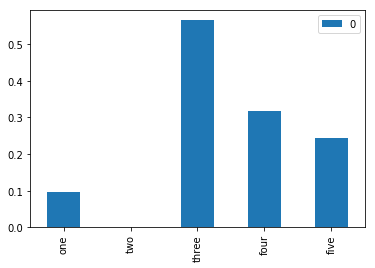

In [66]:
df.plot(kind='bar')

从以上结果中，可以看出，待测文本和第三个文本匹配对最高，符合真实情况（样本空间有限）。

### 文本相似度分析的步骤
* 读取文档
* 对要计算的多篇文档进行分词
* 对文档进行整理成指定格式，方便后续进行计算
* 计算出词语的词频
* 【可选】对词频低的词语进行过滤
* 建立语料库词典
* 加载要对比的文档
* 将要对比的文档通过doc2bow转化为词袋模型
* 对词袋模型进行进一步处理，得到新语料库
* 将新语料库通过tfidfmodel进行处理，得到tfidf
* 通过token2id得到特征数 12、稀疏矩阵相似度，从而建立索引 13、得到最终相似度结果

### 附上更完整示例
测试Python源文件相似度，其中包含主脚本：mydoc_sim.py和其他两个用于对比的脚本程序文件：test_sim_1.py，doc_sim.py，待比对文件：test_sim.py

mydoc_sim.py

```python
# coding: utf-8
import jieba
from gensim import corpora, models, similarities


# Stop words将会用作过滤分词
stop_words = ['，', '。']

test_data_1 = open('test_sim.py').read()
data = open('doc_sim.py').read()
data2 = open('mydoc_sim.py').read()
data3 = open('test_sim_1.py').read()

all_doc = []
all_doc.append(data)
all_doc.append(data2)
all_doc.append(data3)

# 分词
all_doc_list = []
for doc in all_doc:
    doc_list = [word for word in jieba.cut(doc)]
    doc_list = list(set(doc_list) - set(stop_words))
    all_doc_list.append(doc_list)

doc_test_list = [word for word in jieba.cut(test_data_1)]
doc_test_list = list(set(doc_test_list) - set(stop_words))

# 制作词袋: bag-of-words
dictionary = corpora.Dictionary(all_doc_list)
# print(dictionary.keys())
# print(dictionary.token2id)

# 使用doc2bow制作语料库
corpus = [dictionary.doc2bow(doc) for doc in all_doc_list]

doc_test_vec = dictionary.doc2bow(doc_test_list)

# 相似度分析，使用TF-IDF对语料库建模
tfidf = models.TfidfModel(corpus)

# 分析相似度
index = similarities.SparseMatrixSimilarity(
    tfidf[corpus], num_features=len(dictionary.keys())
)
sim = index[tfidf[doc_test_vec]]
print(sorted(enumerate(sim), key=lambda item: -item[1]))
```

test_sim.py

```python
# coding: utf-8
import jieba
from gensim import corpora, models, similarities

doc0 = "我不喜欢上海"
doc1 = "上海是一个好地方"
doc2 = "北京是一个好地方"
doc3 = "上海好吃的在哪里"
doc4 = "上海好玩的在哪里"
doc5 = "上海是好地方"
doc6 = "上海路和上海人"
doc7 = "喜欢小吃"
doc_test="我喜欢上海的小吃"

all_doc = []
all_doc.append(doc0)
all_doc.append(doc1)
all_doc.append(doc2)
all_doc.append(doc3)
all_doc.append(doc4)
all_doc.append(doc5)
all_doc.append(doc6)
all_doc.append(doc7)

all_doc_list = []
for doc in all_doc:
    doc_list = [word for word in jieba.cut(doc)]
    all_doc_list.append(doc_list)

print(all_doc_list)

doc_test_list = [word for word in jieba.cut(doc_test)]

dictionary = corpora.Dictionary(all_doc_list)

corpus = [dictionary.doc2bow(doc) for doc in all_doc_list]

doc_test_vec = dictionary.doc2bow(doc_test_list)

tfidf = models.TfidfModel(corpus)

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
sim = index[tfidf[doc_test_vec]]

print(sorted(enumerate(sim), key=lambda item: -item[1]))
```

doc_sim.py

```python
#coding:utf-8
#使用docsim方法：doc2bow、similarities判断相似性
from gensim import models,corpora,similarities
import jieba.posseg as pseg
import os
import sys

def a_sub_b(a,b):
    ret = []
    for el in a:
        if el not in b:
            ret.append(el)
    return ret

#读取文件
raw_documents=[]
walk = os.walk(os.path.realpath("/root/python_scripts/doc_similarity/doc/"))
for root, dirs, files in walk:
    for name in files:
        f = open(os.path.join(root, name), 'r')
    raw = os.path.join(root, name)+ " "
    raw += f.read()
    raw_documents.append(raw)
stop = [line.strip() for line in open('stopword.txt').readlines() ]
#创建语料库
corpora_documents = []
for item_text in raw_documents:
    item_str=[]
    item= (pseg.cut(item_text)) #使用jieba分词
    for i in list(item):
        item_str.append(i.word)
    item_str=a_sub_b(item_str,list(stop))
    print(item_str)
    #sys.exit(0)
    corpora_documents.append(item_str)

# 生成字典和向量语料
dictionary = corpora.Dictionary(corpora_documents) #把所有单词取一个set，并对set中每一个单词分配一个id号的map
corpus = [dictionary.doc2bow(text) for text in corpora_documents]  #把文档doc变成一个稀疏向量，[(0,1),(1,1)]表明id为0,1的词出现了1次，其他未出现。
similarity = similarities.Similarity('-Similarity-index', corpus, num_features=999999999)

test_data_1 = '本报讯 全球最大个人电脑制造商戴尔公司８日说，由于市场竞争激烈，以及定价策略不当，该公司今年第一季度盈利预计有所下降。'\
'消息发布之后，戴尔股价一度下跌近６％，创下一年来的新低。戴尔公司估计，其第一季度收入约为１４２亿美元，每股收益３３美分。此前公司预测当季收入为１４２亿至１４６亿美元，'\
'每股收益３６至３８美分，而分析师平均预测戴尔同期收入为１４５．２亿美元，每股收益３８美分。为抢夺失去的市场份额，戴尔公司一些产品打折力度很大。戴尔公司首席执行官凯文·罗林斯在一份声明中说，公司在售后服务和产品质量方面一直在投资，同时不断下调价格。戴尔公司将于５月１８日公布第一季度的财报。'
test_cut = pseg.cut(test_data_1)
test_cut_raw_1=[]
for i in list(test_cut):
    test_cut_raw_1.append(i.word)
test_corpus_1 = dictionary.doc2bow(test_cut_raw_1)
similarity.num_best = 5
print(similarity[test_corpus_1])  # 返回最相似的样本材料,(index_of_document, similarity) tuples
for i in similarity[test_corpus_1]:
    sim=""
    print('################################')
    print(i[0])
    for j in corpora_documents[i[0]]:
        sim+=j
print(sim)
```

test_sim_1.py

```python
# coding: utf-8
import jieba
from gensim import corpora, models, similarities

doc0 = "我不喜欢上海"
doc1 = "上海是一个好地方"
doc2 = "北京是一个好地方"
doc3 = "上海好吃的在哪里"
doc6 = "上海路和上海人"
doc7 = "喜欢小吃"
doc_test="我喜欢上海的小吃"

all_document = []
all_document.append(doc0)
all_document.append(doc1)
all_document.append(doc2)
all_document.append(doc3)
all_document.append(doc6)
all_document.append(doc7)

all_document_list = []
for doc in all_document:
    doc_list = [word for word in jieba.cut(doc)]
    all_document_list.append(doc_list)

print(all_document_list)

doc_test_l = [word for word in jieba.cut(doc_test)]

dictionary = corpora.Dictionary(all_document_list)

corpus = [dictionary.doc2bow(doc) for doc in all_document_list]

doc_test_vec = dictionary.doc2bow(doc_test_l)

tfidf = models.TfidfModel(corpus)

index_value = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
sim = index_value[tfidf[doc_test_vec]]

print(sorted(enumerate(sim), key=lambda item: -item[1]))
```

运行结果：

```
(py3) ➜  doc_similarity python mydoc_sim.py
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.526 seconds.
Prefix dict has been built succesfully.
[(2, 0.9530888), (1, 0.070823014), (0, 0.010986276)]
```